# E-Commerce Women Clothing Reviews - Sentiment Prediction
we have a Women's Clothing E-Commerce dataset with the reviews written by customers about the product they purchased. This is my first attempt to deal with text data to predict the sentiments from the review text.

**Data Source and description: [Kaggle](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews)**

## Importing Libraries and Data
Start with importing required libraries and dataset

In [93]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [94]:
#Read in the data
review = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv", index_col = 0)

## Understanding the Data
We have a review dataset of 23486 rows and 10 columns of data. The feature variables are:  
* **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed. 
* **Age**: Positive Integer variable of the reviewers age.
* **Title**: String variable for the title of the review.
* **Review Text**: String variable for the review body.
* **Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
* **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
* **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
* **Division Name**: Categorical name of the product high level division.
* **Department Name**: Categorical name of the product department name.
* **Class Name**: Categorical name of the product class name.

In [95]:
display(review.head())
display(review.shape)
display(review.info())
review.describe(include = 'all')

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


(23486, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


None

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
count,23486.000000,23486.000000,19676,22641,23486.000000,23486.000000,23486.000000,23472,23472,23472
unique,NaN,NaN,13993,22634,NaN,NaN,NaN,3,6,20
top,NaN,NaN,Love it!,Perfect fit and i've gotten so many compliment...,NaN,NaN,NaN,General,Tops,Dresses
freq,NaN,NaN,136,3,NaN,NaN,NaN,13850,10468,6319
mean,918.118709,43.198544,NaN,NaN,4.196032,0.822362,2.535936,NaN,NaN,NaN
std,203.298980,12.279544,NaN,NaN,1.110031,0.382216,5.702202,NaN,NaN,NaN
min,0.000000,18.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,861.000000,34.000000,NaN,NaN,4.000000,1.000000,0.000000,NaN,NaN,NaN
50%,936.000000,41.000000,NaN,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,1078.000000,52.000000,NaN,NaN,5.000000,1.000000,3.000000,NaN,NaN,NaN


In [96]:
#format the column names
review.columns = review.columns.str.lower().str.replace(' ', '_')

Some users have rated the product without writing review, that we have some missing values in the 'title' and 'review_text' columns. To be exact, 845 users have'nt added any review text. 'division_name', 'department_name' and 'class_name' of 14 products are missing. 
As we are trying to predict using 'review_text', there is no use of keeping rows with no 'review_text'. So let's drop those rows.

In [97]:
#Get the index of rows with null review_text
row_index = review[review.review_text.isnull()].index.values

#Drop the 845 rows with missing text
review_df = review.drop(row_index, axis = 0).reset_index()
review_df.shape

(22641, 11)

## Data Preprocessing & NLP
Now we need to clean the text data and create a *Corpus* by following the given:
* Transform words to lowercase
* Remove unwanted words like special characters and numbers.
* Remove stopwords
* Stemming: Stemming will reduce noise in the text by transforming words to their base form.

In [98]:
ps = PorterStemmer()
stemmed_words = []
for i in range(len(review_df['review_text'])):
    review_text = re.sub('[^a-zA-Z]', ' ', review_df['review_text'][i])
    review_text = review_text.lower()
    review_text = review_text.split()
    #Remove stop words and stemming
    review_text = [ps.stem(word) for word in review_text if not word in stopword_list]
    review_text = ' '.join(review_text)
    stemmed_words.append(review_text)


We have features like **Rating** (1 to 5), and **Recommended IND** (0 or 1). Recommended IND is a binary variable where 1 is recommended and, 0 is not recommended. We can either use any of these features to figure out sentiments of the feature:
* Best rating can be considered as **Positive** and worst rating can be considered **Negative**
* Using Recommended IND, 0 can be considered **Negative** and 1 as **Positive**.

There are customers who has given rating of 2 or 1 and at the same time they have written very positive review and they recommends the product. Some customers has written postive review and rated 5 but they do not recomments the product(example below). In such a situation, labeling the reviews based on any one of these two features would be a bad idea. 
So I'm going to use **Rating** and **Recommended IND** for labeling positive or negative(Positive as 1 and Negative as 0).
* Review associated with Rating 4 and 5 is considered Positive regardless of the Recommended IND
* If the rating is 3 or less and Recommended IND is 1 is also considered positive
* If the rating is 3 or less and Recommended IND is 0 which is considered negative.

In [111]:
display(review_df[(review_df.rating == 1) & (review_df.recommended_ind == 1)].head(3))
review_df[(review_df.rating == 5) & (review_df.recommended_ind == 0)].head(3)

,index,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
2344,2427,939,39,NaN,Beautiful jacket and i got lots of compliments...,1,1,0,General,Tops,Sweaters
2777,2872,829,51,NaN,Very cute top. i went down a size because for ...,1,1,1,General Petite,Tops,Blouses
5370,5570,861,69,Great t,I love this t-shirt because it has the combina...,1,1,0,General,Tops,Knits


,index,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
1285,1333,836,25,"Cute shirt, but not for me",The blue lace with the white top underneath is...,5,0,0,General,Tops,Blouses
3375,3499,872,52,Love this top!,This top is one of my retailer faves! it is so...,5,0,2,General,Tops,Knits
3728,3863,1081,53,Love this dress,"I also have this dress in 3/4 sleeve, tegan tu...",5,0,0,General Petite,Dresses,Dresses


In [130]:
#function to create sentiment label
def sentiment_label(row):
    if row['rating'] > 3:
        val = 1
    elif (row['rating'] <= 3) & (row['rating'] == 1):
        val = 1
    else:
        val = 0
    return val

#Create a sentiment column
review_df['sentiment'] = review_df.apply(sentiment_label, axis = 1)

review_df.head(3)

,index,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,1
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0


In [131]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(stemmed_words)
y = review_df.copy().sentiment


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [133]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [134]:
prediction = lr.predict(X_test)


In [135]:
print(accuracy_score(y_test, prediction))

0.8477300830242007


In [141]:
cm = confusion_matrix(y_test, prediction)
cm

array([[ 508,  540],
       [ 322, 4291]])

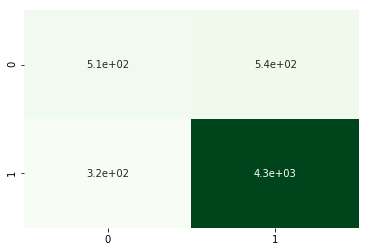

In [142]:
sns.heatmap(cm, annot = True, cmap="Greens",cbar=False)
plt.show()

In [138]:
lr.score(X_train, y_train)

0.9098351001177857

In [139]:
lr.score(X_test, y_test)

0.8477300830242007

In [140]:
f1_score(y_test, prediction)

0.9087251164760695

The linear regression model has 90.8% accuracy on the test data.